In [1]:
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Embedding, Activation, Bidirectional, LSTM
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
import re
import nltk
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

2023-05-04 23:51:31.279797: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os,random,math
TRAINING_DIR="propaganda_dataset_v2"

files=os.listdir(TRAINING_DIR)

trainingdf= pd.read_csv(os.path.join(TRAINING_DIR,files[1]),sep = '\t')
testingdf= pd.read_csv(os.path.join(TRAINING_DIR,files[2]),sep = '\t')

In [3]:
def convert_token(sentences):
    start_sent = sentences.replace("<BOS>","")
    end_sent =start_sent.replace("<EOS>","")
    return end_sent

In [4]:
testingdf["tagged_in_context"]=testingdf["tagged_in_context"].map(convert_token)
trainingdf["tagged_in_context"]=trainingdf["tagged_in_context"].map(convert_token)

In [6]:
binaryclass_traindf=trainingdf
binaryclass_testdf=testingdf

In [7]:
def replace_labels(label):
    return 1 if label=="not_propaganda" else 0
binaryclass_testdf["label"]= binaryclass_testdf["label"].map(replace_labels)
binaryclass_traindf["label"]=binaryclass_traindf["label"].map(replace_labels)
binaryclass_traindf

,label,tagged_in_context
0,1,"No, he will not be confirmed."
1,1,This declassification effort won’t make thing...
2,0,The Obama administration misled the American ...
3,1,“It looks like we’re capturing the demise of t...
4,1,"Location: Westerville, Ohio"
...,...,...
2409,1,We support and appreciate your business.”
2410,1,International Atomic Energy Agency (IAEA) Dire...
2411,1,What has been done: there has been work on for...
2412,1,This is the law of gradualness not the gradua...


In [8]:
def text_preprocessing(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    stops = stopwords.words('english')
    #print(stops)
    
    return sentence.lower()

In [9]:
binaryclass_testdf["tagged_in_context"]=binaryclass_testdf["tagged_in_context"].map(text_preprocessing)
binaryclass_traindf["tagged_in_context"]=binaryclass_traindf["tagged_in_context"].map(text_preprocessing)

In [10]:
from keras.utils import to_categorical
y_train = to_categorical(binaryclass_traindf["label"])
y_test = to_categorical(binaryclass_testdf["label"])

In [11]:
from keras.preprocessing.text import Tokenizer
no_words=10000
tokenizer=Tokenizer(num_words=no_words,lower=True)

In [13]:
mes = []
for i in binaryclass_testdf['tagged_in_context']:
    mes.append(i.split())
for i in binaryclass_traindf['tagged_in_context']:
    mes.append(i.split())

In [14]:
tokenizer.fit_on_texts(mes)

In [16]:
X_train=tokenizer.texts_to_sequences(binaryclass_traindf["tagged_in_context"])  
X_train_pad=pad_sequences(X_train,maxlen=140,padding='post') 
X_test = tokenizer.texts_to_sequences(binaryclass_testdf["tagged_in_context"])
X_test_pad = pad_sequences(X_test, maxlen = 140, padding = 'post')

In [17]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [18]:
vector_size = 100
gensim_weight_matrix = np.zeros((no_words ,vector_size))
gensim_weight_matrix.shape
words = list(glove_gensim.key_to_index.keys())
for word, index in tokenizer.word_index.items():
    if index < no_words: 
        if word in  words:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

In [19]:
EMBEDDING_DIM = 100
class_num = 2
model = Sequential()
model.add(Embedding(input_dim = no_words,
 output_dim = EMBEDDING_DIM,
 input_length= X_train_pad.shape[1],
 weights = [gensim_weight_matrix],trainable = False))


model.add(Bidirectional(LSTM(100,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200,return_sequences=False)))
model.add(Dense(class_num, activation = "sigmoid"))
model.compile(loss = "binary_crossentropy", optimizer = "adam",metrics = "accuracy")

In [20]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 140, 100)          1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 140, 200)         160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 140, 200)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 140, 400)         641600    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 140, 400)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 400)              9

In [22]:
history_embedding = model.fit(X_train_pad, y_train, 
                                epochs = 25, batch_size = 120, 
                                validation_data=(X_test_pad, y_test),
                                verbose = 1, callbacks= [es, mc]  )

Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 0.6497 - accuracy: 0.6276
Epoch 1: val_accuracy improved from -inf to 0.61897, saving model to ./model.h5
21/21 [==============================] - 26s 1s/step - loss: 0.6497 - accuracy: 0.6276 - val_loss: 0.6392 - val_accuracy: 0.6190
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 0.5888 - accuracy: 0.6993
Epoch 2: val_accuracy improved from 0.61897 to 0.71379, saving model to ./model.h5
21/21 [==============================] - 21s 1s/step - loss: 0.5888 - accuracy: 0.6993 - val_loss: 0.5728 - val_accuracy: 0.7138
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 0.5504 - accuracy: 0.7216
Epoch 3: val_accuracy improved from 0.71379 to 0.73103, saving model to ./model.h5
21/21 [==============================] - 21s 1s/step - loss: 0.5504 - accuracy: 0.7216 - val_loss: 0.5730 - val_accuracy: 0.7310
Epoch 4/25
21/21 [==============================] - ETA: 0s - loss: 0.5386 - accuracy

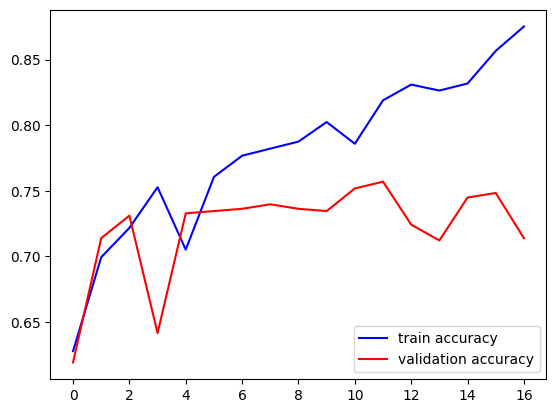

In [23]:
import matplotlib.pyplot as plt
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [24]:
y_pred =   np.argmax(model.predict(X_test_pad), axis  =  1)
y_true = np.argmax(y_test, axis = 1)
from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))

19/19 [==============================] - 3s 125ms/step
              precision    recall  f1-score   support

           0       0.85      0.66      0.74       363
           1       0.58      0.81      0.68       217

    accuracy                           0.71       580
   macro avg       0.72      0.73      0.71       580
weighted avg       0.75      0.71      0.72       580



In [26]:
y_pred = model.predict(X_test_pad)
y_pred
threshold=0.5
binary_labels = np.where(y_pred >= threshold, 1, 0)


y_pred = model.predict(X_test_pad)
y_pred = np.argmax (y_pred, axis = 1)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: ", accuracy_score(y_test, binary_labels))
print("Precision: ", precision_score(y_test, binary_labels, average='macro'))
print("Recall: ", recall_score(y_test, binary_labels, average='macro'))
print("F1 Score: ", f1_score(y_test, binary_labels, average='macro'))

19/19 [==============================] - 2s 124ms/step
Accuracy:  0.7120689655172414
Precision:  0.7333536453771058
Recall:  0.7188821014777504
F1 Score:  0.7104848506717665
